### 1. Language detection
There are three languages: A, B, and C. Each language uses the same set of symbols: “A, o, e, t, p, g, and k. However, each language uses the symbols differently. In each of these languages we can model everything as P(next symbol | current symbol).

There is training data available for each language. This consists of several files each generated by sampling from a Markov model. Using python, build a Markov model for each of the languages.
Now use the Markov model and Bayes’ rule to classify the test cases. Write down how you used Bayes’ rule to get your classifier. Give the full posterior distribution for each test case.


In [2]:
import glob
import os
import numpy as np

def loadfile(filename):
    filelist = glob.glob(os.path.join(os.getcwd(),filename))
    corpus = []
    for filename in filelist:
        with open(filename) as f:
            corpus.append(f.read())
    return corpus
trainA = loadfile('symbol/language-training-langA*')
trainB = loadfile('symbol/language-training-langB*')
trainC = loadfile('symbol/language-training-langC*')

test = loadfile('symbol/language-test*')


In [3]:
'''
The transition matrices contain all the conditional probabilities representing 
P(next letter = b|current letter = a), which is specific for each language and 
therefore obtained from the training sets
'''
def make_matrix(traindata):
    #since there are 7 symbols in total
    matrix = np.zeros((7,7))
    symbols = list(set(traindata[0]))
    
    for n in range(len(traindata)):
        for i in range(len(traindata[n])-1):
            for s in range(len(symbols)):
                if traindata[n][i] == symbols[s]:
                    
                    for j in range(len(symbols)):
                        if traindata[n][i+1] == symbols[j]:
                            matrix[s][j] += 1
    matrix = matrix / matrix.sum(axis=1)[:, None] 
    #^normalize so it yields probablities
    return matrix 

In [4]:
TA = make_matrix(trainA)
TB = make_matrix(trainB)
TC = make_matrix(trainC)

In [7]:
from numpy import prod
def compute_probs(test,symbols):
    for a in test:
        n = len(a)
        pA = []
        pB = []
        pC = []
        for i in range(0,n-1):
            for j in range(len(symbols)):
                if a[i] == symbols[j]:
                    x1 = j
                if a[i+1] == symbols[j]:
                    x2 = j    
            pA.append(TA[x1][x2]) 
            pB.append(TB[x1][x2])
            pC.append(TC[x1][x2])
        #I didn't include the prior 1/3 because they are the same for all three languages
        PA = prod(pA)
        PB = prod(pB)
        PC = prod(pC)
        #pick the language that has the largest probablity
        probs = [PA,PB,PC]
        if PA == max(probs):
            lang = "A"
        if PB == max(probs):
            lang = "B"
        if PC == max(probs):
            lang = "C"
        print a
        print "Posteriors:", probs
        print "Result: Language",lang
            
symbols = list(set(trainA[0]))
compute_probs(test,symbols)

pppooootgAookggggtttopAtttkkkeeggeeeeAAAgtkoAkkkkkooppppttppppppgppteoooooottkttttkkkktAAApgookkkkkp
Posteriors: [9.1838228620700886e-124, 0.0, 1.7471154742448771e-63]
Result: Language C
gooooAAAAAAAAAkkkkkkooooAAAeppppppgeeeeepAAppeektetttgggogptttttttkppAAAApetAeegggtttteetttttppAAAAA
Posteriors: [4.135682666245436e-124, 0.0, 8.9367171957579954e-57]
Result: Language C
ekogoAgkepokogoppAttpAttgeekApegepApotpAAtpetgAtpopAttpAppAtkokettkgAttggokoogApppepogeApopogetpokog
Posteriors: [3.8865019380325041e-72, 0.0, 3.9352820076084801e-106]
Result: Language A
AtAgegegegAgegetoAtetAogAooAoeAtegAgeotAoAgoetAteAteoegoeogetekoAoegAoegAtegAgeotAtAoAtetAtgeggAtAto
Posteriors: [1.5306220726654159e-104, 4.5539394744288479e-59, 2.8125987297193343e-117]
Result: Language B
popoktgopogettpegAtkegotkogettpApepApegtgApeogokokApetkAgegokpepketpotttpAtkopepototpApettgotokotgok
Posteriors: [2.1957391056304064e-66, 0.0, 2.9017488527140014e-112]
Result: Language A
okopottogttpetgopopotkepeppAgAgetpotpAtgookett

### 2. Speaker identification

There are three people in a room. Each says about 10 phonemes, before being randomly interrupted by someone else. When they speak they all sound the same, however each person tends to use different phonemes in their speech. Specifically we can model the following transition probabilities that someone will interrupt the current speaker: P(speaker i at time t+1 | speaker j at time t). We can also model the probability over phonemes given a particular speaker: P(phoneme | speaker i). The phonemes are identical to the ones introduced in problem 1 (but the transition matrices are obviously different, since they take a different form altogether).

- Write down the update equations that you will need to train a hidden Markov model. Using the information given above, write down a sensible initialization for the transition matrix.
- Write your own python code to train a hidden Markov model on the data. You may look at code online, but will need to reference any code that helps you with your implementation.
- From matplotlb use a stackplot (https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.stackplot.html) to show the probability of a particular person speaking.

The update equation (induction step) is the following: 

$$ \alpha_j(t+1) = \sum_{i=1}^{N}{ \alpha_i(t)\alpha[x_i,x_j]b[x_j,o_{t+1}] }$$

where 

- $a_i(t)$ = predicted probability at time t-1
- $a[x_i, x_j]$ = transition probabilities, 3x3 matrix from speaker to speaker at t to t+1
- $b[x_k | o_{t+1}]$ = hidden speaker given observed data, or probability each speaker says that phoneme. Here, we're assuming each speaker says each phoneme with some probability unrelated to the phoneme spoken before.

Note, the source for update Equation is: https://people.cs.umass.edu/~mccallum/courses/inlp2004a/lect10-hmm2.pdf


In [82]:
import hmmlearn as hmm

with open('speaker.txt') as f:
    recording = f.read()
phones = list(set(recording))
print phones, len(phones)

#Initial probablities - generated arbitrarily
a = np.array([0.2,0.3,0.5])
#Initialize the transition matrix
t = np.full((3, 3), 0.05)
for i in range(0,3):
    t[i][i] = 0.9 
#Initialize a random emission matrix
e = np.zeros((3,7))
for i in range(0,3):
    p = np.random.dirichlet(np.ones(7),size=1) #the row needs to sum to 1
    e[i,:]= p[0]
print a #starting probabilities
print t #transition matrix
print e #emission matrix


['A', 'e', 'g', 'k', 'o', 'p', 't'] 7
[ 0.2  0.3  0.5]
[[ 0.9   0.05  0.05]
 [ 0.05  0.9   0.05]
 [ 0.05  0.05  0.9 ]]
[[ 0.22619443  0.37236587  0.05718209  0.0511308   0.12507326  0.16174921
   0.00630433]
 [ 0.24885377  0.04873048  0.0213211   0.09506037  0.13501072  0.12681288
   0.32421068]
 [ 0.11340719  0.06662832  0.10013853  0.12521446  0.28500115  0.06770393
   0.24190641]]


In [83]:
transitions = list(zip(recording, recording[1:]))
mapping = {letter: index for (index, letter) in enumerate(phones)}
mapped_data = [mapping[v] for v in recording]
#mapped_transitions = [(mapping[a], mapping[b]) for (a, b) in transitions]
mapped_data = np.asarray(mapped_data).reshape(-1,1)
#The code above is adapted from Guy Davidson's HMM template on #CS156_ml Slack channel

In [84]:
from hmmlearn import hmm
hmm = hmm.MultinomialHMM(n_components=3, n_iter=100, init_params='ste')

hmm.startprob_ = a
hmm.transmat_ = t
hmm.emissionprob_ = e

hmm.fit(mapped_data)
speaker = hmm.predict(mapped_data)
print speaker

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0
 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0
 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 1 1 1 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [88]:
print hmm.transmat_
print hmm.emissionprob_
print hmm.monitor_

[[ 0.79228595  0.19658694  0.01112711]
 [ 0.17763597  0.55918628  0.26317774]
 [ 0.03497132  0.02194586  0.94308282]]
[[  5.19236953e-01   4.40002379e-04   2.75780439e-03   5.80777720e-02
    6.50742406e-02   2.75469237e-02   3.26866304e-01]
 [  1.36155573e-01   1.42190001e-01   1.28084764e-01   1.69016246e-02
    7.54846583e-05   3.77513932e-05   5.76554800e-01]
 [  6.72045281e-02   1.88601055e-01   1.59817262e-01   3.69593048e-02
    2.67703688e-01   2.48105227e-01   3.16089347e-02]]
ConvergenceMonitor(history=[-1730.5800150635635, -1730.4874220708357],
          iter=100, n_iter=100, tol=0.01, verbose=False)


In [92]:
probs = hmm.predict_proba(mapped_data)
print probs
print len(speaker)

[[  2.14987718e-263   2.26050934e-090   1.00000000e+000]
 [  9.14704397e-004   3.46175508e-006   9.99081834e-001]
 [  7.91791472e-005   1.06568036e-002   9.89264017e-001]
 ..., 
 [  7.45871506e-004   3.86529708e-006   9.99250263e-001]
 [  1.34902210e-003   1.37881373e-006   9.98649599e-001]
 [  1.01965261e-002   6.86179666e-006   9.89796612e-001]]
1000


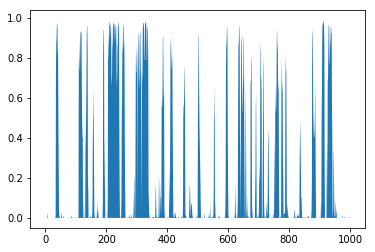

In [99]:
import matplotlib.pyplot as plt

x = range(0,1000)

y0 = probs[:,0]
y1 = probs[:,1]
y2 = probs[:,2]

fig, ax = plt.subplots()
ax.stackplot(x, y0) 
plt.show()


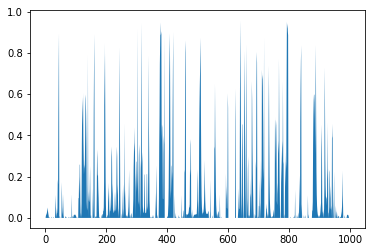

In [100]:
fig, ax = plt.subplots()
ax.stackplot(x, y1) 
plt.show()

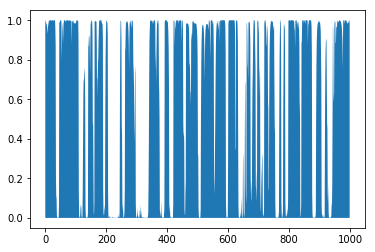

In [101]:
fig, ax = plt.subplots()
ax.stackplot(x, y2) 
plt.show()